In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
plt.style.use('ggplot')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ravik\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\ravik\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\ravik\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [3]:
df = pd.read_csv('Reviews.csv')
print("Original DataFrame shape:", df.shape)
df = df.head(500)
print("Reduced DataFrame shape:", df.shape)

Original DataFrame shape: (568454, 10)
Reduced DataFrame shape: (500, 10)


## Data Visualization

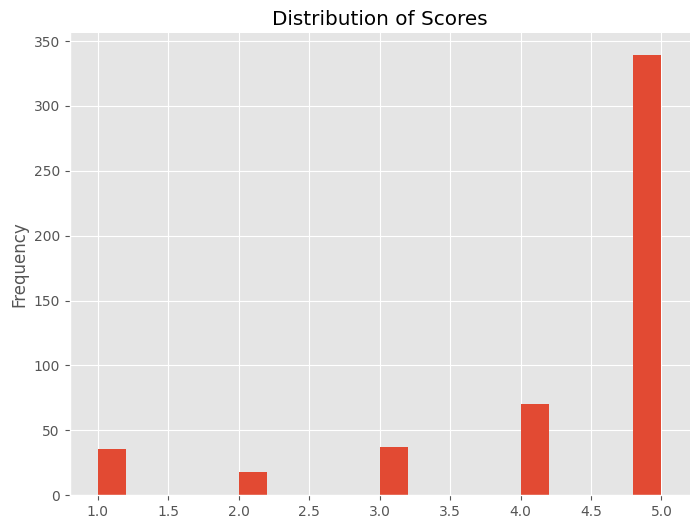

In [4]:
# Score distribution
plt.figure(figsize=(8, 6))
df['Score'].plot(kind='hist', bins=20, title='Distribution of Scores')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

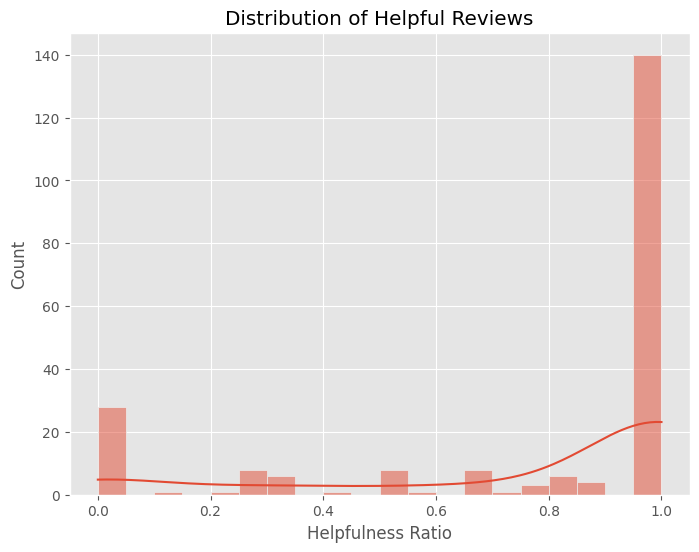

In [5]:
# Helpfulness Ratio distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'], bins=20, kde=True)
plt.title('Distribution of Helpful Reviews')
plt.xlabel('Helpfulness Ratio')
plt.ylabel('Count')
plt.show()

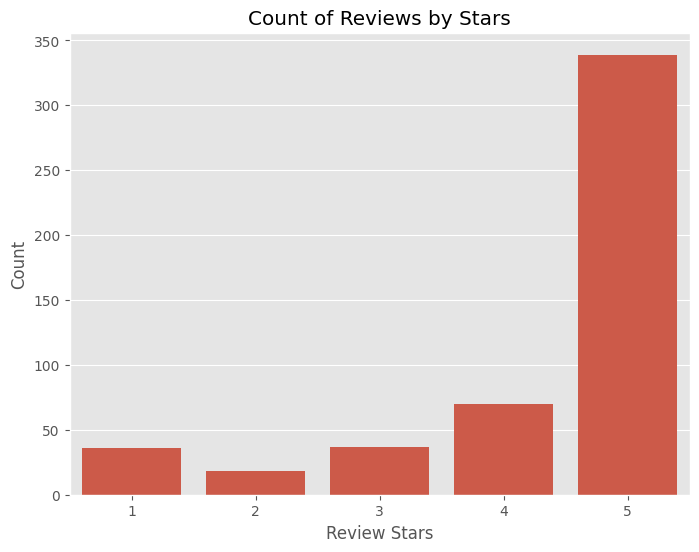

In [6]:
# Count of Reviews by Stars
plt.figure(figsize=(8, 6))
sns.countplot(x='Score', data=df)
plt.title('Count of Reviews by Stars')
plt.xlabel('Review Stars')
plt.ylabel('Count')
plt.show()

## Models VADER and ROBERTA

In [7]:
sia = SentimentIntensityAnalyzer()
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [8]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [9]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {f"vader_{key}": value for key, value in vader_result.items()}
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [10]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

## VADER Results

C:\Users\ravik\AppData\Local\Temp\ipykernel_14176\209347458.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=results_df, x='Score', y='vader_compound', ci=None)


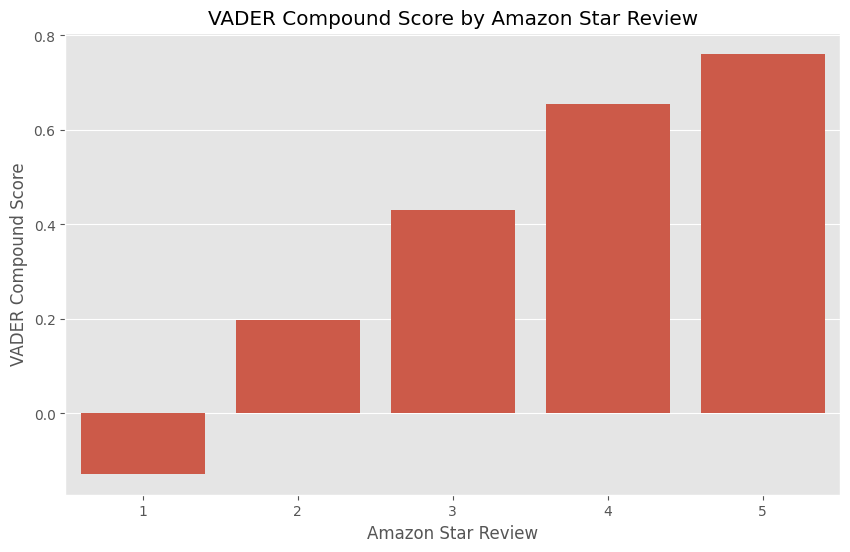

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Score', y='vader_compound', ci=None)
plt.title('VADER Compound Score by Amazon Star Review')
plt.xlabel('Amazon Star Review')
plt.ylabel('VADER Compound Score')
plt.show()

## ROBERTA Results

C:\Users\ravik\AppData\Local\Temp\ipykernel_14176\3008219425.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=results_df, x='Score', y='roberta_pos', ax=axs[0], ci=None)
C:\Users\ravik\AppData\Local\Temp\ipykernel_14176\3008219425.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=results_df, x='Score', y='roberta_neu', ax=axs[1], ci=None)
C:\Users\ravik\AppData\Local\Temp\ipykernel_14176\3008219425.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=results_df, x='Score', y='roberta_neg', ax=axs[2], ci=None)


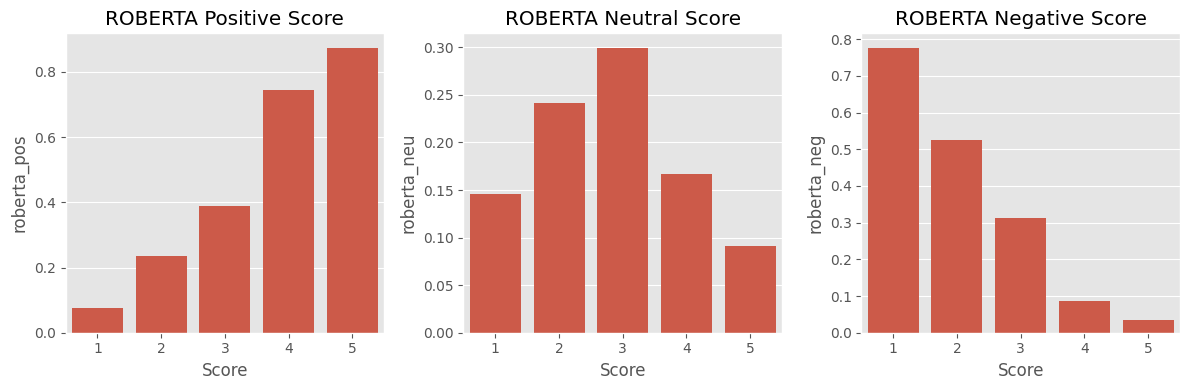

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
sns.barplot(data=results_df, x='Score', y='roberta_pos', ax=axs[0], ci=None)
sns.barplot(data=results_df, x='Score', y='roberta_neu', ax=axs[1], ci=None)
sns.barplot(data=results_df, x='Score', y='roberta_neg', ax=axs[2], ci=None)
axs[0].set_title('ROBERTA Positive Score')
axs[1].set_title('ROBERTA Neutral Score')
axs[2].set_title('ROBERTA Negative Score')
plt.tight_layout()
plt.show()

In [13]:
## VADER and ROBERTA Results

In [14]:
# ROC curve and ROC area for VADER model
fpr_vader, tpr_vader, _ = roc_curve(results_df['Score'] > 3, results_df['vader_pos'])
roc_auc_vader = auc(fpr_vader, tpr_vader)

# ROC curve and ROC area for ROBERTA model
fpr_roberta, tpr_roberta, _ = roc_curve(results_df['Score'] > 3, results_df['roberta_pos'])
roc_auc_roberta = auc(fpr_roberta, tpr_roberta)

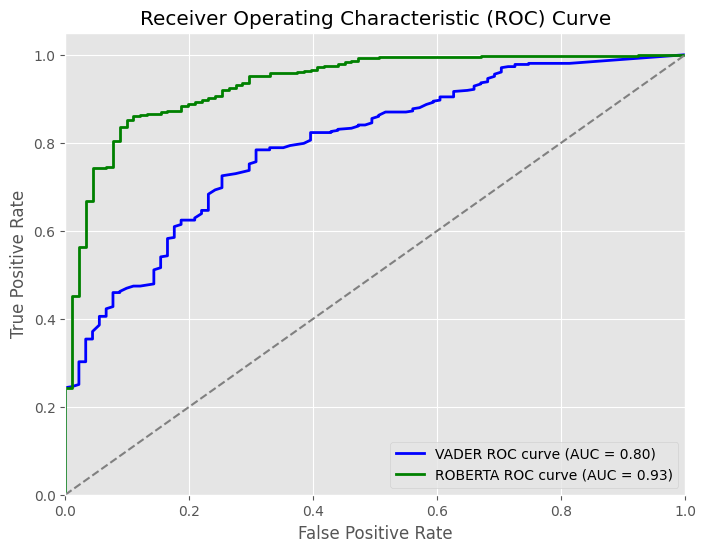

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_vader, tpr_vader, color='blue', lw=2, label=f'VADER ROC curve (AUC = {roc_auc_vader:.2f})')
plt.plot(fpr_roberta, tpr_roberta, color='green', lw=2, label=f'ROBERTA ROC curve (AUC = {roc_auc_roberta:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [16]:
# precision-recall curve and area for VADER model
precision_vader, recall_vader, _ = precision_recall_curve(results_df['Score'] > 3, results_df['vader_pos'])
pr_auc_vader = auc(recall_vader, precision_vader)

# precision-recall curve and area for ROBERTA model
precision_roberta, recall_roberta, _ = precision_recall_curve(results_df['Score'] > 3, results_df['roberta_pos'])
pr_auc_roberta = auc(recall_roberta, precision_roberta)

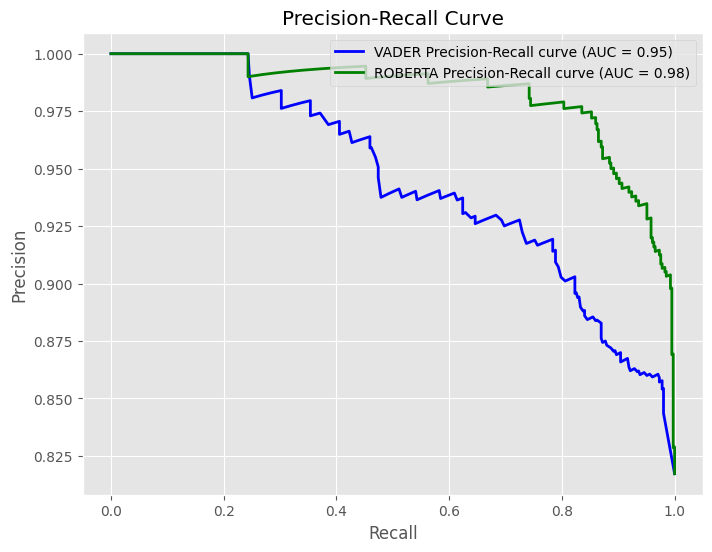

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(recall_vader, precision_vader, color='blue', lw=2, label=f'VADER Precision-Recall curve (AUC = {pr_auc_vader:.2f})')
plt.plot(recall_roberta, precision_roberta, color='green', lw=2, label=f'ROBERTA Precision-Recall curve (AUC = {pr_auc_roberta:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')

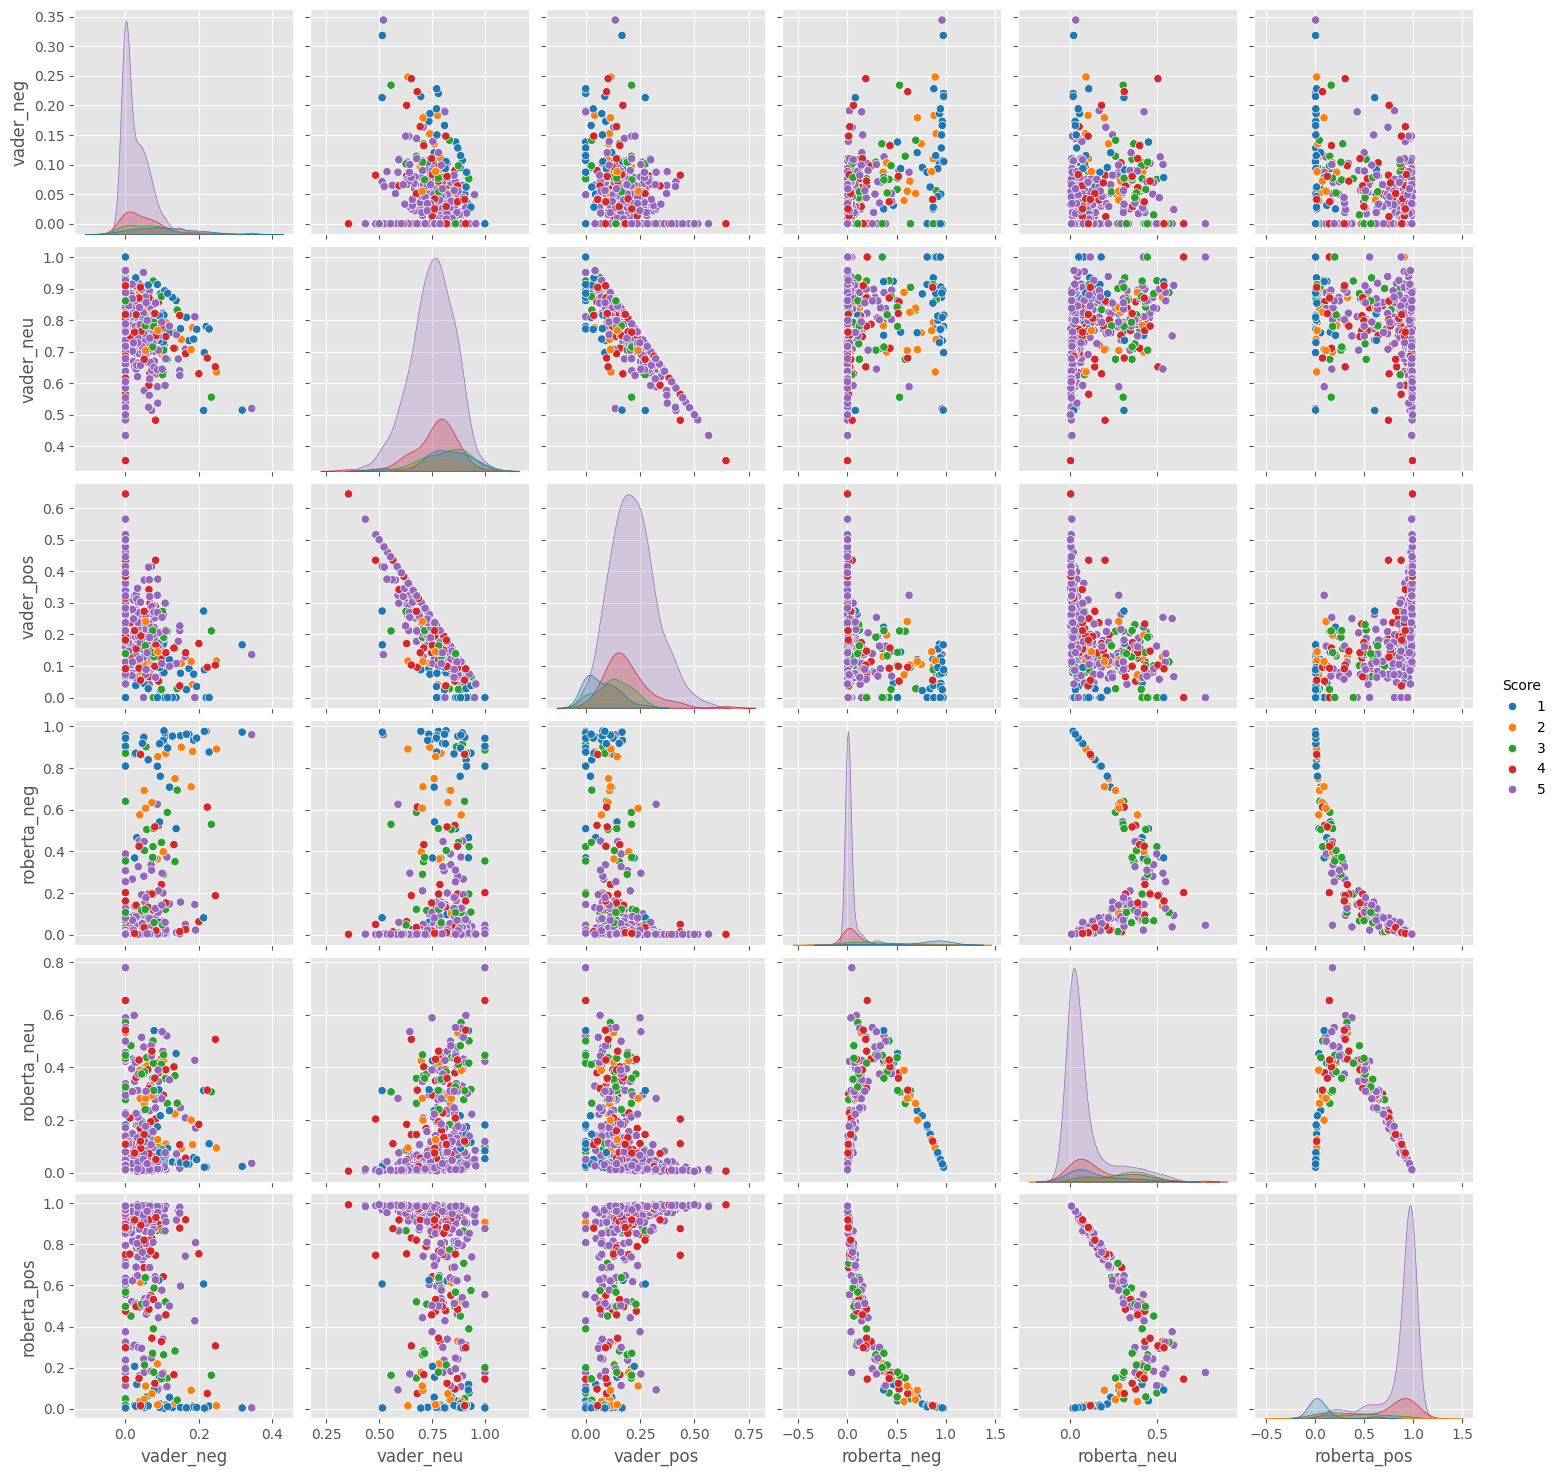

In [18]:
# Visualize VADER and ROBERTA results
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue='Score', palette='tab10')
plt.show()

## Rating-Text Mismatch Reviews

In [19]:
def print_mismatch_review(df, sentiment_tool, sentiment_key, rating, sort_by):
    mismatch_review = df.query(f'Score == {rating}').sort_values(sentiment_key, ascending=False)['Text'].values[5]
    print(f"{sentiment_tool} sentiment star-{rating} review:")
    print(mismatch_review)

In [20]:
# Positive sentiment star-1 review using VADER
print_mismatch_review(results_df, "VADER", 'vader_pos', 1, 'vader_pos')

VADER sentiment star-1 review:
Serveice delivery with the seller was excellent. The product was not. Will not order again. Bad taste. Iam not sure if it was old or that how it tastes. I throw it right away, i coudl not drink it.


In [21]:
# Positive sentiment star-1 review using ROBERTA
print_mismatch_review(results_df, "ROBERTA", 'roberta_pos', 1, 'roberta_pos')

ROBERTA sentiment star-1 review:
My cats have been happily eating Felidae Platinum for more than two years. I just got a new bag and the shape of the food is different. They tried the new food when I first put it in their bowls and now the bowls sit full and the kitties will not touch the food. I've noticed similar reviews related to formula changes in the past. Unfortunately, I now need to find a new food that my cats will eat.


In [22]:
# Negative sentiment star-5 reviw using VADER
print_mismatch_review(results_df, "VADER", 'vader_neg', 5, 'vader_neg')

VADER sentiment star-5 review:
I drive OTR...Over the Road truck and this helps to keep me alert. It has no sugar high & no crash. I'm on a autoship which i like. The price is very good. I've seen it over 2 bucks in the store.


In [23]:
#Negative sentiment star-5 review using ROBERTA
print_mismatch_review(results_df, "ROBERTA", 'roberta_neg', 5, 'roberta_neg')

ROBERTA sentiment star-5 review:
One of my boys needed to lose some weight and the other didn't.  I put this food on the floor for the chubby guy, and the protein-rich, no by-product food up higher where only my skinny boy can jump.  The higher food sits going stale.  They both really go for this food.  And my chubby boy has been losing about an ounce a week.


In [24]:
def get_positive_words(text):
    tokens = word_tokenize(text.lower())
    positive_words = [word for word in tokens if word not in stopwords.words('english') and word.isalpha() and word not in ['not', 'no', 'never']]
    return ' '.join(positive_words)

In [25]:
results_df['Positive_Words'] = results_df['Text'].apply(get_positive_words)
all_positive_words = ' '.join(results_df['Positive_Words'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(all_positive_words)

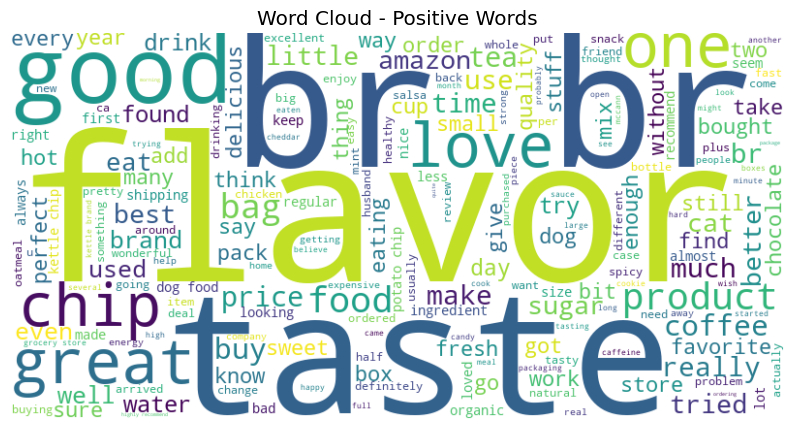

In [26]:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud - Positive Words')
plt.axis('off')
plt.show()

## Model Evaluation 

In [27]:
results_df['vader_sentiment'] = results_df['vader_pos'] > results_df['vader_neg']
results_df['roberta_sentiment'] = results_df['roberta_pos'] > results_df['roberta_neg']

In [28]:
# accuracy
vader_accuracy = accuracy_score(results_df['Score'] > 3, results_df['vader_sentiment'])
roberta_accuracy = accuracy_score(results_df['Score'] > 3, results_df['roberta_sentiment'])

In [29]:
# precision
vader_precision = precision_score(results_df['Score'] > 3, results_df['vader_sentiment'])
roberta_precision = precision_score(results_df['Score'] > 3, results_df['roberta_sentiment'])

In [30]:
# recall
vader_recall = recall_score(results_df['Score'] > 3, results_df['vader_sentiment'])
roberta_recall = recall_score(results_df['Score'] > 3, results_df['roberta_sentiment'])

In [31]:
# F1-score
vader_f1 = f1_score(results_df['Score'] > 3, results_df['vader_sentiment'])
roberta_f1 = f1_score(results_df['Score'] > 3, results_df['roberta_sentiment'])

In [32]:
print("VADER Model Metrics:")
print(f"Accuracy: {vader_accuracy:.2f}")
print(f"Precision: {vader_precision:.2f}")
print(f"Recall: {vader_recall:.2f}")
print(f"F1-score: {vader_f1:.2f}")

print("\nROBERTA Model Metrics:")
print(f"Accuracy: {roberta_accuracy:.2f}")
print(f"Precision: {roberta_precision:.2f}")
print(f"Recall: {roberta_recall:.2f}")
print(f"F1-score: {roberta_f1:.2f}")

VADER Model Metrics:
Accuracy: 0.85
Precision: 0.88
Recall: 0.94
F1-score: 0.91

ROBERTA Model Metrics:
Accuracy: 0.91
Precision: 0.93
Recall: 0.95
F1-score: 0.94
